# Project Modeling

### 1. Read Data

In [2]:
import numpy as np
import pandas as pd
import os, re
from konlpy.tag import Twitter
from gensim.models.doc2vec import LabeledSentence, Doc2Vec
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

os.chdir('D:/UNIST/18-1학기 자료/tm')

In [3]:
# read data
df=pd.read_csv('formodeling_revised.csv',encoding='utf_8',index_col=0)
print('shape of the data set :',df.shape)

shape of the data set : (38613, 3)


### 1-1. Train & Test Set split

In [21]:
# split train test data (영화별 비율 유지)
train,test = train_test_split(df, random_state=42, train_size=0.8, test_size=0.2, stratify=df.answer)

print('unique number of movie in train data: ',len(train.answer.value_counts().index))
print('unique number of movie in train data: ',len(test.answer.value_counts().index),'\n')
print('train data shape: ',train.shape)
print('test data shape: ',test.shape)

unique number of movie in train data:  3788
unique number of movie in train data:  2720 

train data shape:  (30890, 3)
test data shape:  (7723, 3)


## 2. Pos tagging with Twitter - 명사, 형용사, 동사

In [11]:
# unique 한 영화만 들어있는 새로운 dataframe 만들기
uniq_movie=df.loc[:,['synopsis','answer']].drop_duplicates().reset_index(drop=True)
print('shape of unique movie dataset :', uniq_movie.shape)

shape of unique movie dataset : (3938, 2)


In [8]:
stop_words=['영화','설명','외국영화','죄송합니다','제목','페북','내용','배우','기억','영화관','어릴때','알려','답변','내공','혹시',
            '주인공','일본','장르','장면','년도','년전','꼭좀','찾다','예전','티비','프로그램','질문','외국','유명하다']

In [6]:
import time
start = time.time();

# 특정 태그만 남기기 Twitter version synopsis
tw=Twitter()
synop_list=[]
for synop in dff.synopsis:
    synop=tw.pos(synop,norm=True,stem=True)
    word_list=[]
    for word, tag in synop:
        if tag in ['Noun','Adjective','Verb']:
            if len(word)>1:
                word_list.append(word)
    synop_list.append(word_list)
    
end = time.time();
print(end-start)

31.673808813095093


In [9]:
# 특정 태그만 남기기 Twitter version train_question
start = time.time();
question_list=[]
for q in train.question:
    q=tw.pos(q,norm=True,stem=True)
    word_list=[]
    for word, tag in q:
        if tag in ['Noun','Adjective','Verb']:
            if len(word)>1:
                if word not in stop_words:
                    word_list.append(word)
    question_list.append(word_list)
    
end = time.time();
print(end-start)

145.14981484413147


# 3. Doc2vec modeling

### 1) Labeled sentence 생성 for modeling

In [10]:
# labeled sentence 생성
from gensim.models.doc2vec import LabeledSentence, Doc2Vec, TaggedDocument

doc_list=[]
dff_index=list(dff.answer)
train_index=list(train.answer)

# synopsis만 추가
for i in range(len(dff)):
    doc=TaggedDocument(synop_list[i], [dff_index[i]])
    doc_list.append(doc)

# train question 추가
for i in range(len(train)):
    doc=TaggedDocument(question_list[i], [train_index[i]])
    doc_list.append(doc)    

### 2) Query setting for outout

In [11]:
# Queary setting 
start = time.time();

query_list=[]
for q in test.question:
    q=tw.pos(q,norm=True,stem=True)
    word_list=[]
    for word, tag in q:
        if tag in ['Noun','Adjective','Verb']:
            if len(word)>1:
                if word not in stop_words:
                    word_list.append(word)
    query_list.append(word_list)
    
end = time.time();
print(end-start)

33.45218849182129


### 3) making accuracy estimate function

In [12]:
# return accuracy function
def get_model_accuracy(model,t):
    # query input
    acc_list=[]
    test_answer_list=list(test.answer)

    i=0
    for query in query_list:
        new_vector = model.infer_vector(query,alpha=0.001)
        sims = model.docvecs.most_similar([new_vector],topn=t)

        # 정확도 구하기
        accuracy=[]
        output_list=[]
    
        for title, similarity in sims:
            output_list.append(title)
       
        if test_answer_list[i] in output_list:
            accuracy.append(1)
        else:
            accuracy.append(0)
    
        i=i+1

        acc_list.append(sum(accuracy))

    results=(sum(acc_list)/len(acc_list))
    
    return results

In [ ]:
# return correct index list
def get_correct_movie_info(model):
    # query input
    correct_list_index=[]
    wrong_list_index=[]
    
    test_answer_list=list(test.answer)

    i=0
    for query in query_list:
        new_vector = model.infer_vector(query,alpha=0.001)
        sims = model.docvecs.most_similar([new_vector])

        # 맞춘 영화 정보 구하기
        output_list=[]

        for title, similarity in sims:
            output_list.append(title)
        
        if test_answer_list[i] in output_list:
            correct_list_index.append(i)
        else:
            wrong_list_index.append(i)
            
        i=i+1
    
    return correct_list_index

### 4) parameter tuning for best parameter setting

#### prameter 

dm ‘distributed memory’ (PV-DM) is used. 
size is the dimensionality of the feature vectors.  
window is the maximum distance between the predicted word and context words used for prediction within a document.  
alpha is the initial learning rate (will linearly drop to min_alpha as training progresses).  
seed = for the random number generator.  
min_count = ignore all words with total frequency lower than this.  
iter = number of iterations (epochs) over the corpus.   
hs = 1, hierarchical softmax will be used for model training.   
negative = negative sampling will be used, the int for negative specifies how many “noise words” should be drawn 

In [13]:
# modeling
model = Doc2Vec(doc_list, alpha=0.1, size= 300, window = 6, min_count = 1, workers=1, seed = 42, iter=5, hs=1,negative=3)

36.92737126350403


In [ ]:
# get accuracy
print(get_model_accuracy(model,10))

### 5) Results analysis

In [64]:
# get correct data frame
c=get_correct_movie_info(model)
correct_df=test.iloc[c,:]

In [15]:
# make accuracy list
acc=[]
for i in range(1,11):
    acc.append(get_model_accuracy(model,i))

print(acc)

[0.5738702576718892, 0.6311019034054124, 0.6585523760196814, 0.678622297034831, 0.6926065000647417, 0.7067201864560404, 0.7126764210798913, 0.7234235400751003, 0.7261426906642496, 0.7357244594069662]


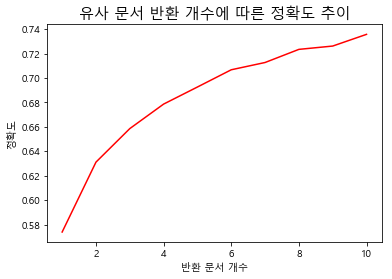

In [163]:
# 정답 선정 개수 기준에 따른 정확도 변화 plot

#matplotlib 한글 깨짐 방지 코드
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name) 

# plot
plt.plot(range(1,11), acc, color='red')
plt.title("유사 문서 반환 개수에 따른 정확도 추이",fontsize=15)
plt.xlabel('반환 문서 개수')
plt.ylabel('정확도')
plt.show()

In [102]:
# 
min_c=min(correct_df['count'])
max_c=max(correct_df['count'])
correct_count_list=[]

min_t=min(test['count'])
max_t=max(test['count'])
all_count_list=[]

for i in range(min_c,max_c):
    correct_count_list.append(sum(correct_df['count']==i))
    
for i in range(min_t,max_t):
    all_count_list.append(sum(test['count']==i))

In [177]:
rate=[]
for i in range(len(all_count_list)):
    rate.append(correct_count_list[i]/(all_count_list[i]+1))

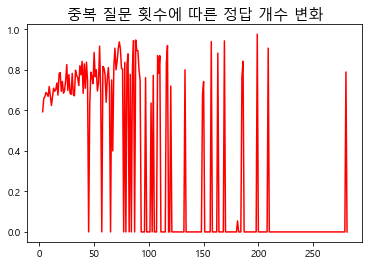

In [179]:
# 영화당 질문별 
#plt.plot(range(min_t,max_t), all_count_list, color='blue')
plt.plot(range(min_c,max_c), rate, color='red')
plt.title("중복 질문 횟수에 따른 정답 개수 변화",fontsize=15)
plt.show()

In [ ]:
# plot
plt.plot(range(1,21), acc, color='red')

plt.title("정답 선정 개수 기준에 따른 정확도 변화 (n=1~20)",fontsize=15)
plt.show()

### 6) Results (Accuracy)

#### score board topn=20
model = Doc2Vec(doc_list, alpha=0.1, size= 300, window = 6, min_count = 1, workers=1, seed = 42, iter=5, hs=1,negative=3) --> 77.5

#### score board topn=10
model = Doc2Vec(doc_list, size= 300, window = 6, min_count = 1, workers=1, seed = 42, iter=5, hs=1) --> 52.8  
model = Doc2Vec(doc_list, alpha=0.1, size= 300, window = 6, min_count = 1, workers=1, seed = 42, iter=5, hs=1,negative=3) --> 73.5

#### score board topn=5
model = Doc2Vec(doc_list, alpha=0.1, size= 300, window = 6, min_count = 1, workers=1, seed = 42, iter=5, hs=1,negative=3) --> 69


#### score board topn=1
model = Doc2Vec(doc_list, alpha=0.1, size= 300, window = 6, min_count = 1, workers=1, seed = 42, iter=5, hs=1,negative=3) --> 57.3


## 7) save model

In [ ]:
# store the model to mmap-able files
model.save('my_model.doc2vec')
#load the model back
#model_loaded = Doc2Vec.load('my_model.doc2vec')

In [147]:
test2=pd.DataFrame.reset_index(test,drop=True)

In [157]:
print(query_list[6809])

['보이다', '할아버지', '죽다', '보상금', '받다', '도둑', '보상금', '훔치다', '들어가다', '지하', '여자', '있다', '그렇다', '스릴러', '걸깨']


In [154]:
# query input
new_vector = model.infer_vector(query_list[6809],alpha=0.001)
sims = model.docvecs.most_similar([new_vector])
sims

[('맨 인 더 다크', 0.1963629275560379),
 ('종횡사해', 0.1927681565284729),
 ('프리즌 히트', 0.19275511801242828),
 ('스턱', 0.18937425315380096),
 ('1408', 0.188787579536438),
 ('로스트 하이웨이', 0.17300422489643097),
 ('다크 엔젤', 0.17231591045856476),
 ('페이백', 0.16933536529541016),
 ('휴먼 센티피드', 0.16795529425144196),
 ('파커', 0.1645517796278)]

In [ ]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus))
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

# 아래는 참고 코드

### 3) TF-IDF Synopsis

In [223]:
# TF-IDF 만들기 (synopsis)
corpus=[]
for doc in synop_list:
    corpus.append(' '.join(doc))

In [148]:
# TF-IDF modeling
#idf_maker=TfidfVectorizer(min_df=3)
#tf_idf=idf_maker.fit_transform(corpus).toarray()

In [ ]:
idf_maker = TfidfVectorizer(min_df=2)
tf_idf = idf_maker.fit_transform(word_list).toarray()
tf_idf_dtm = pd.DataFrame(tf_idf, columns= idf_maker.get_feature_names(), 
                      index= ['taxi', 'gunhamdo', 'young_police', 'war_of_species', 'nomuhyun', 'summer_500', 'dung','sunshine',
                              'annabel', 'spiderman'])
tf_idf_dtm

In [ ]:
# 중복제거
def remove_duplicates(li):
    my_set=set()
    res=[]
    for e in li:
        if e not in my_set:
            res. append(e)
            my_set.add(e)
    return res

# Babel practice code

- 대학생 커뮤니티에서 수집한 174만개의 문장을 Step2에서의 방법으로 형태소 분석하고, 단어의 리스트 포맷으로 만듦.  
- 포맷 : [ ["word1/pos1", "word2/pos2", "word3/pos3", ... ], ["word4/pos4", "word5/pos5", ... ], ... ] 
- __사정상 데이터는 공개 불가 ㅜ__

- 앞서 만든 word2vec 모델은 기존 1-hot 벡터표현법에 비해 차원(dimension)이 상당히 줄어들었지만, 그래도 300차원..
- 이를 평면상에 시각화해보기 위해서는 t-SNE를 이용하여 차원을 2차원으로 축소해야함.
- t-SNE는 scikit-learn에서 제공.

In [259]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [260]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000) 
# 여기서 중요한 것은 n_components만큼 차원을 축소함. Cartarian 좌표계로 시각화하기 위해 2차원으로 축소.

In [261]:
# numpy객체 출력시 소숫점 출력안함
np.set_printoptions(suppress=True)

In [264]:
vectors = model_w2v.syn0
labels = model_w2v.index2word

AttributeError: 'Word2Vec' object has no attribute 'syn0'

In [ ]:
# 이것도 오오오오오오래걸림...
import time
start = time.time();
vectors_simple = tsne.fit_transform(vectors)
end = time.time();
print end -start

In [ ]:
# 차원축소된 벡터 저장.
#with open('vectors_simple.txt', 'w') as f:
#    pickle.dump(vectors_simple, f)

In [ ]:
# 저장된 벡터 불러오기.
#with open('vectors_simple.txt', 'rb') as f:   
#    vectors_simple = pickle.load(f)

In [ ]:
from bokeh.plotting import figure, show, output_notebook, output_file

In [ ]:
#output_file("word2vec_tsne.html") # 시각화 결과물을 "word2vec_tsne.html" 이름으로 export
output_notebook() # 시각화 결과물을 jupyter 노트북에 보여줌.

In [ ]:
from bokeh.models import HoverTool, ColumnDataSource

source = ColumnDataSource(
        data=dict(
            x=vectors_simple.T[0],
            y=vectors_simple.T[1],
            word=labels,
        )
    )


hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("word", "@word"),
        ]
    )
TOOLS = "pan,wheel_zoom,box_zoom,reset,resize"

In [ ]:
p = figure(plot_width=700, plot_height=700, tools=[TOOLS,hover], title="Words of Univ Students")
p.circle('x', 'y', size=7, source=source, alpha=0.4, fill_color="red", line_color="#ff9900")

show(p)

In [ ]:
# 강의 코드 
lines=text.split('\r\n')
result=[]
for line in lines:
    r=[]
    malist=twitter.pos(line, norm=True, stem=True)
    for (word, pumsa) in malist:
        if not mumsa in ['josa']:
            r.append(word)
    result.append((" ".join(r)).strip())
    
output=(" ".join(results)).strip()

with open('aa.txt','w', encoding='utf-8') as fp:
    fp.write(output)

data=word2vec.Linesentenc('adf.wakati')
model=word2vec.Word2Vec(data, size=200, window=10, hs=1, min_count=2, sq=1)
model.save("")


noun_adv_verb_only_list = [word, part for word, part in test_docs1[10][0] if part == "Verb" or part == "Adjective" or part == "Noun"]

# unload useless memory
model.init_sims(replace=True)

# 강의 코드 
lines=text.split('\r\n')
result=[]
for line in lines:
    r=[]
    malist=twitter.pos(line, norm=True, stem=True)
    for (word, pumsa) in malist:
        if not mumsa in ['josa']:
            r.append(word)
    result.append((" ".join(r)).strip())
    
output=(" ".join(results)).strip()
